<a href="https://colab.research.google.com/github/IronABC/Pairing_Similar_Questions/blob/main/Quora_Question_Pairing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data_frame = pd.read_csv('/content/drive/My Drive/data_set/train.csv')

In [6]:
data_frame.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [7]:
data_frame.shape

(404290, 6)

In [8]:
data_frame[data_frame.isnull().any(axis=1)].count()

id              3
qid1            3
qid2            3
question1       2
question2       1
is_duplicate    3
dtype: int64

In [9]:
data_frame.dropna(axis=0, how='any', inplace=True)
data_frame.shape

(404287, 6)

In [10]:
data_frame[data_frame.isnull().any(axis=1)].count()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


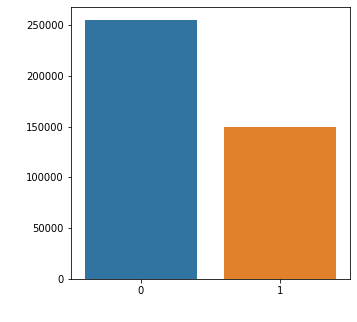

In [11]:
is_dup = data_frame['is_duplicate'].value_counts()
plt.figure(figsize=(5,5))
sns.barplot(is_dup.index, is_dup.values)
plt.xlabel("Is Duplicate", fontsize=15, color='w')
plt.ylabel('Counts', fontsize=15, color='w')
plt.show()

In [12]:
train_qs = pd.Series(data_frame['question1'].tolist()+data_frame['question2'].tolist(), ).astype(str)
train_qs.shape[0]/data_frame.shape[0]

2.0

In [13]:
train_qs[0]

'What is the step by step guide to invest in share market in india?'

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'No of words in question')

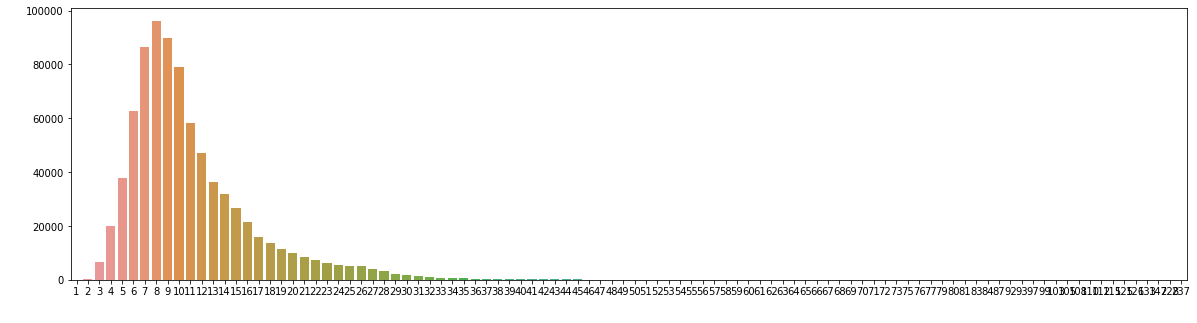

In [14]:
all_ques = train_qs.apply(lambda x: len(str(x).split()))
cnt = all_ques.value_counts()
plt.figure(figsize=(20, 5))
sns.barplot(cnt.index, cnt.values)
plt.ylabel('No of questions', fontsize=15, color='w')
plt.xlabel('No of words in question', fontsize=15, color='w')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'No of characters in question')

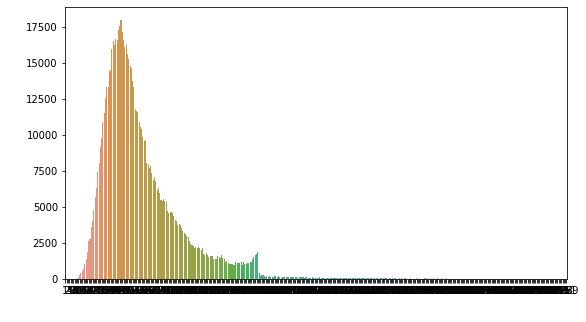

In [15]:
char_len = train_qs.apply(lambda x: len(str(x)))
cnt = char_len.value_counts()
plt.figure(figsize=(9, 5))
sns.barplot(cnt.index, cnt.values)
plt.ylabel('No of questions', fontsize=15, color='w')
plt.xlabel('No of characters in question', fontsize=15, color='w')

In [16]:
word = " ".join(train_qs).lower().split()
print("length of word = {} \nFirst word = {}".format(len(word), word[0]))

length of word = 8944556 
First word = what


In [17]:
#counting the frequenct of each word and storing it in a container named counts 
from collections import Counter
counts = Counter(word)
counts['what']

310962

In [18]:
#now setting up weight for each word
def get_weight(count, epsilon=10000, min_count=2):
  return 0 if count<min_count else 1/(count+epsilon)
weights = {word:get_weight(count) for word, count in counts.items()}

In [19]:
import nltk
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [71]:
x = pd.DataFrame()

In [72]:
q1_list = str(data_frame['question1']).lower().split()
q1 = set(q1_list)
q1_words = q1.difference(stop_words)

q2_list = str(data_frame['question2']).lower().split()
q2 = set(q2_list)
q2_words = q2.difference(stop_words)

q1_stop = q1.intersection(stop_words) 
q2_stop = q2.intersection(stop_words)

q1_bigram = set([i for i in zip(q1_list, q1_list[1:])])
q2_bigram = set([i for i in zip(q2_list, q2_list[1:])])

common_bigram = q1_bigram.intersection(q2_bigram)
common_words = q1.intersection(q2)

q1_weights = [weights.get(wrd, 0) for wrd in q1_words]
q2_weights = [weights.get(wrd, 0) for wrd in q2_words]
common_weight = [weights.get(wrd, 0) for wrd in common_words]
total_weights = q1_weights + q2_weights

Rcosine_denominator = (np.sqrt(np.dot(q1_weights,q1_weights))*np.sqrt(np.dot(q2_weights,q2_weights)))
Rcosine_denominator

2.706750662013944e-07

In [73]:
word_hamming = sum(1 for i in zip(q1_list, q2_list) if i[0]==i[1] )/max(len(q1_list), len(q2_list))

In [74]:
def word_shares(row):
  q1_list = str(row[3]).lower().split()
  q1 = set(q1_list)
  q1words = q1.difference(stop_words)
  if len(q1words) == 0:
      return '0:0:0:0:0:0:0:0'
  
  q2_list = str(row[4]).lower().split()
  q2 = set(q2_list)
  q2words = q2.difference(stop_words)
  if len(q2words) == 0:
      return '0:0:0:0:0:0:0:0'
  words_hamming = sum(1 for i in zip(q1_list, q2_list) if i[0]==i[1])/max(len(q1_list), len(q2_list))
  q1stops = q1.intersection(stop_words)
  q2stops = q2.intersection(stop_words)
  q1_2gram = set([i for i in zip(q1_list, q1_list[1:])])
  q2_2gram = set([i for i in zip(q2_list, q2_list[1:])])
  shared_2gram = q1_2gram.intersection(q2_2gram)
  shared_words = q1words.intersection(q2words)
  shared_weights = [weights.get(w, 0) for w in shared_words]
  q1_weights = [weights.get(w, 0) for w in q1words]
  q2_weights = [weights.get(w, 0) for w in q2words]
  total_weights = q1_weights + q1_weights
  
  R1 = np.sum(shared_weights) / np.sum(total_weights) #tfidf share
  R2 = len(shared_words) / (len(q1words) + len(q2words) - len(shared_words)) #count share
  R31 = len(q1stops) / len(q1words) #stops in q1
  R32 = len(q2stops) / len(q2words) #stops in q2
  Rcosine_denominator = (np.sqrt(np.dot(q1_weights,q1_weights))*np.sqrt(np.dot(q2_weights,q2_weights)))
  Rcosine = np.dot(shared_weights, shared_weights)/Rcosine_denominator
  if len(q1_2gram) + len(q2_2gram) == 0:
      R2gram = 0
  else:
      R2gram = len(shared_2gram) / (len(q1_2gram) + len(q2_2gram))
  return '{}:{}:{}:{}:{}:{}:{}:{}'.format(R1, R2, len(shared_words), R31, R32, R2gram, Rcosine, words_hamming)

In [75]:
data_frame.head()
data_frame['word_shares'] = data_frame.apply(word_shares, axis=1, raw=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


In [76]:
data_frame.head()

,id,qid1,qid2,question1,question2,is_duplicate,word_shares
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.3725595356751943:0.5714285714285714:4:1.0:1....
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.2565225100964912:0.18181818181818182:2:1.0:0...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.17150662515468013:0.2222222222222222:2:1.333...
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.0:0.0:0:1.5:0.8:0.0:0.0:0.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.0:0.0:0:0.3:0.4:0.0:0.0:0.07692307692307693


In [77]:
print(data_frame['word_shares'][0])
print(data_frame['word_shares'][1])
print(data_frame['word_shares'][2])
print(data_frame['word_shares'][3])
print(data_frame['word_shares'][4])

0.3725595356751943:0.5714285714285714:4:1.0:1.2:0.4166666666666667:0.7951924319230587:0.7857142857142857
0.2565225100964912:0.18181818181818182:2:1.0:0.3333333333333333:0.05263157894736842:0.410927039622762:0.07692307692307693
0.17150662515468013:0.2222222222222222:2:1.3333333333333333:1.0:0.045454545454545456:0.3408833660992533:0.14285714285714285
0.0:0.0:0:1.5:0.8:0.0:0.0:0.0
0.0:0.0:0:0.3:0.4:0.0:0.0:0.07692307692307693


In [78]:
x = pd.DataFrame()
x['word_match']       = data_frame['word_shares'].apply(lambda x: float(x.split(':')[0]))
x['word_match_2root'] = np.sqrt(x['word_match'])
x['tfidf_word_match'] = data_frame['word_shares'].apply(lambda x: float(x.split(':')[1]))
x['shared_count']     = data_frame['word_shares'].apply(lambda x: float(x.split(':')[2]))
x['stops1_ratio']     = data_frame['word_shares'].apply(lambda x: float(x.split(':')[3]))
x['stops2_ratio']     = data_frame['word_shares'].apply(lambda x: float(x.split(':')[4]))
x['shared_2gram']     = data_frame['word_shares'].apply(lambda x: float(x.split(':')[5]))
x['cosine']           = data_frame['word_shares'].apply(lambda x: float(x.split(':')[6]))
x['words_hamming']    = data_frame['word_shares'].apply(lambda x: float(x.split(':')[7]))
x['diff_stops_r']     = x['stops1_ratio'] - x['stops2_ratio']
x['len_q1'] = data_frame['question1'].apply(lambda x: len(str(x)))
x['len_q2'] = data_frame['question2'].apply(lambda x: len(str(x)))
x['diff_len'] = x['len_q1'] - x['len_q2']

x['caps_count_q1'] = data_frame['question1'].apply(lambda x:sum(1 for i in str(x) if i.isupper()))
x['caps_count_q2'] = data_frame['question2'].apply(lambda x:sum(1 for i in str(x) if i.isupper()))
x['diff_caps'] = x['caps_count_q1'] - x['caps_count_q2']
x['len_char_q1'] = data_frame['question1'].apply(lambda x: len(str(x).replace(' ', '')))
x['len_char_q2'] = data_frame['question2'].apply(lambda x: len(str(x).replace(' ', '')))
x['diff_len_char'] = x['len_char_q1'] - x['len_char_q2']
x['len_word_q1'] = data_frame['question1'].apply(lambda x: len(str(x).split()))
x['len_word_q2'] = data_frame['question2'].apply(lambda x: len(str(x).split()))
x['diff_len_word'] = x['len_word_q1'] - x['len_word_q2']
x['avg_world_len1'] = x['len_char_q1'] / x['len_word_q1']
x['avg_world_len2'] = x['len_char_q2'] / x['len_word_q2']
x['diff_avg_word'] = x['avg_world_len1'] - x['avg_world_len2']
x['exactly_same'] = (data_frame['question1'] == data_frame['question2']).astype(int)
x['duplicated'] = data_frame.duplicated(['question1','question2']).astype(int)

In [79]:
x['exactly_same'] = (data_frame['question1'] == data_frame['question2']).astype(int)
x['duplicated'] = data_frame.duplicated(['question1','question2']).astype(int)

In [80]:
def add_word_count(x, df, word):
    x['q1_' + word] = df['question1'].apply(lambda x: (word in str(x).lower())*1)
    x['q2_' + word] = df['question2'].apply(lambda x: (word in str(x).lower())*1)
    x[word + '_both'] = x['q1_' + word] * x['q2_' + word]


add_word_count(x, data_frame,'how')
add_word_count(x, data_frame,'what')
add_word_count(x, data_frame,'which')
add_word_count(x, data_frame,'who')
add_word_count(x, data_frame,'where')
add_word_count(x, data_frame,'when')
add_word_count(x, data_frame,'why')

In [81]:
x.columns

Index(['word_match', 'word_match_2root', 'tfidf_word_match', 'shared_count',
       'stops1_ratio', 'stops2_ratio', 'shared_2gram', 'cosine',
       'words_hamming', 'diff_stops_r', 'len_q1', 'len_q2', 'diff_len',
       'caps_count_q1', 'caps_count_q2', 'diff_caps', 'len_char_q1',
       'len_char_q2', 'diff_len_char', 'len_word_q1', 'len_word_q2',
       'diff_len_word', 'avg_world_len1', 'avg_world_len2', 'diff_avg_word',
       'exactly_same', 'duplicated', 'q1_how', 'q2_how', 'how_both', 'q1_what',
       'q2_what', 'what_both', 'q1_which', 'q2_which', 'which_both', 'q1_who',
       'q2_who', 'who_both', 'q1_where', 'q2_where', 'where_both', 'q1_when',
       'q2_when', 'when_both', 'q1_why', 'q2_why', 'why_both'],
      dtype='object')

In [82]:
x.describe()

,word_match,word_match_2root,tfidf_word_match,shared_count,stops1_ratio,stops2_ratio,shared_2gram,cosine,words_hamming,diff_stops_r,len_q1,len_q2,diff_len,caps_count_q1,caps_count_q2,diff_caps,len_char_q1,len_char_q2,diff_len_char,len_word_q1,len_word_q2,diff_len_word,avg_world_len1,avg_world_len2,diff_avg_word,exactly_same,duplicated,q1_how,q2_how,how_both,q1_what,q2_what,what_both,q1_which,q2_which,which_both,q1_who,q2_who,who_both,q1_where,q2_where,where_both,q1_when,q2_when,when_both,q1_why,q2_why,why_both
count,403850.000000,403850.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,403503.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.0,404287.0,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000
mean,0.211045,0.405511,0.305237,2.119596,1.007549,1.017716,0.122985,0.409500,0.221450,-0.010167,59.536997,60.108507,-0.571510,2.713646,2.764009,-0.050363,49.592359,49.923361,-0.331002,10.942256,11.182017,-0.239760,4.582692,4.521823,0.060870,0.0,0.0,0.270887,0.274360,0.171415,0.396763,0.391160,0.271112,0.053732,0.053494,0.021794,0.033390,0.034409,0.016360,0.022318,0.022239,0.009332,0.032289,0.031737,0.010742,0.101297,0.101136,0.051780
std,0.150129,0.215883,0.254596,1.723616,0.487865,0.489760,0.129799,0.294229,0.271029,0.511660,29.940553,33.863588,32.566186,2.396500,2.450618,2.473446,24.785740,27.803732,26.750844,5.428812,6.305210,6.078812,0.834293,0.814860,0.803563,0.0,0.0,0.444418,0.446192,0.376872,0.489227,0.488011,0.444534,0.225488,0.225017,0.146010,0.179652,0.182277,0.126855,0.147717,0.147461,0.096153,0.176767,0.175300,0.103087,0.301722,0.301509,0.221583
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.250000,1.000000,1.000000,-1080.000000,0.000000,0.000000,-111.000000,1.000000,1.000000,-857.000000,1.000000,1.000000,-223.000000,1.000000,1.000000,-22.500000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.092266,0.303754,0.111111,1.000000,0.666667,0.666667,0.000000,0.175420,0.000000,-0.261538,39.000000,39.000000,-11.000000,1.000000,1.000000,-1.000000,33.000000,32.000000,-9.000000,7.000000,7.000000,-2.000000,4.000000,4.000000,-0.375000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.201044,0.448380,0.250000,2.000000,1.000000,1.000000,0.083333,0.392266,0.107143,0.000000,52.000000,51.000000,0.000000,2.000000,2.000000,0.000000,43.000000,42.000000,0.000000,10.000000,10.000000,0.000000,4.500000,4.428571,0.035714,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.323254,0.568555,0.444444,3.000000,1.250000,1.250000,0.200000,0.627567,0.363636,0.250000,72.000000,72.000000,12.000000,3.000000,4.000000,1.000000,60.000000,60.000000,10.000000,13.000000,13.000000,2.000000,5.000000,5.000000,0.485714,0.0,0.0,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.500000,0.707107,1.000000,23.000000,8.000000,8.000000,0.500000,1.000000,1.000000,6.750000,623.000000,1169.000000,487.000000,111.000000,112.000000,110.000000,499.000000,942.000000,389.000000,125.00

In [83]:
x.fillna(0)
x.shape

(404287, 48)

In [84]:
x.head(10)

,word_match,word_match_2root,tfidf_word_match,shared_count,stops1_ratio,stops2_ratio,shared_2gram,cosine,words_hamming,diff_stops_r,len_q1,len_q2,diff_len,caps_count_q1,caps_count_q2,diff_caps,len_char_q1,len_char_q2,diff_len_char,len_word_q1,len_word_q2,diff_len_word,avg_world_len1,avg_world_len2,diff_avg_word,exactly_same,duplicated,q1_how,q2_how,how_both,q1_what,q2_what,what_both,q1_which,q2_which,which_both,q1_who,q2_who,who_both,q1_where,q2_where,where_both,q1_when,q2_when,when_both,q1_why,q2_why,why_both
0,0.372560,0.610377,0.571429,4.0,1.000000,1.200000,0.416667,0.795192,0.785714,-0.200000,66,57,9,1,1,0,53,46,7,14,12,2,3.785714,3.833333,-0.047619,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.256523,0.506481,0.181818,2.0,1.000000,0.333333,0.052632,0.410927,0.076923,0.666667,51,88,-37,5,5,0,44,76,-32,8,13,-5,5.500000,5.846154,-0.346154,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.171507,0.414134,0.222222,2.0,1.333333,1.000000,0.045455,0.340883,0.142857,0.333333,73,59,14,5,5,0,60,50,10,14,10,4,4.285714,5.000000,-0.714286,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.000000,0.000000,0.0,1.500000,0.800000,0.000000,0.000000,0.000000,0.700000,50,65,-15,4,1,3,40,57,-17,11,9,2,3.636364,6.333333,-2.696970,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,0.000000,0.000000,0.000000,0.0,0.300000,0.400000,0.000000,0.000000,0.076923,-0.100000,76,39,37,1,1,0,64,33,31,13,7,6,4.923077,4.714286,0.208791,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0.269175,0.518820,0.307692,4.0,0.875000,0.777778,0.100000,0.488688,0.250000,0.097222,86,90,-4,5,6,-1,71,75,-4,16,16,0,4.437500,4.687500,-0.250000,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.000000,0.000000,0.000000,0.0,1.000000,0.428571,0.000000,0.000000,0.000000,0.571429,19,62,-43,2,1,1,16,52,-36,4,11,-7,4.000000,4.727273,-0.727273,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0.385400,0.620806,0.333333,1.0,2.500000,3.500000,0.071429,0.748695,0.111111,-1.000000,30,41,-11,2,2,0,24,33,-9,7,9,-2,3.428571,3.666667,-0.238095,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0.198258,0.445262,0.333333,2.0,1.000000,1.000000,0.285714,0.318783,0.750000,0.000000,31,37,-6,1,1,0,24,30,-6,8,8,0,3.000000,3.750000,-0.750000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0
9,0.239904,0.489800,0.222222,2.0,0.500000,0.800000,0.062500,0.506342,0.000000,-0.300000,60,49,11,8,6,2,52,41,11,9,9,0,5.777778,4.555556,1.222222,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [85]:
print(list(x.columns.values))

['word_match', 'word_match_2root', 'tfidf_word_match', 'shared_count', 'stops1_ratio', 'stops2_ratio', 'shared_2gram', 'cosine', 'words_hamming', 'diff_stops_r', 'len_q1', 'len_q2', 'diff_len', 'caps_count_q1', 'caps_count_q2', 'diff_caps', 'len_char_q1', 'len_char_q2', 'diff_len_char', 'len_word_q1', 'len_word_q2', 'diff_len_word', 'avg_world_len1', 'avg_world_len2', 'diff_avg_word', 'exactly_same', 'duplicated', 'q1_how', 'q2_how', 'how_both', 'q1_what', 'q2_what', 'what_both', 'q1_which', 'q2_which', 'which_both', 'q1_who', 'q2_who', 'who_both', 'q1_where', 'q2_where', 'where_both', 'q1_when', 'q2_when', 'when_both', 'q1_why', 'q2_why', 'why_both']


**Feature Engineering**

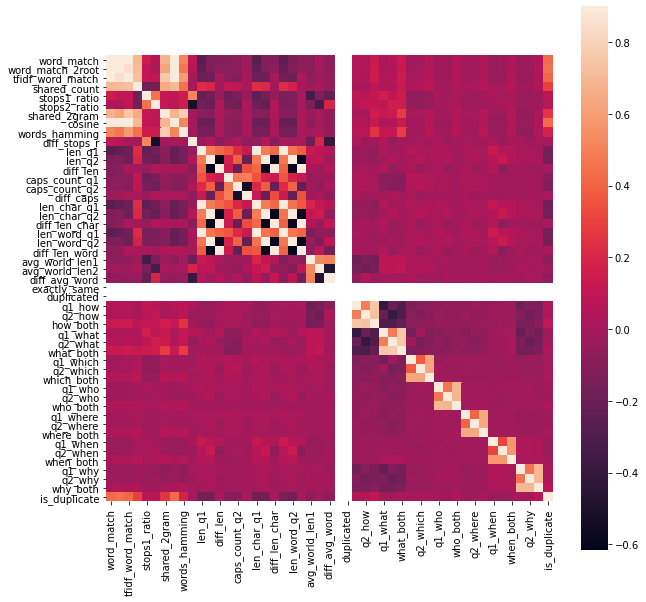

In [86]:
x['is_duplicate'] = data_frame['is_duplicate']
plt.subplots(figsize=(10,10))
sns.heatmap(x.corr(), vmax=0.9, square=True)

In [87]:
from sklearn.model_selection import train_test_split
#x = x.drop(labels=['is_duplicate'], axis=1, inplace=False)
y = x.is_duplicate
x.drop(labels=['is_duplicate'], inplace=True, axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print(x.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(404287, 48)
(283000, 48)
(283000,)
(121287, 48)
(121287,)


In [88]:
param = {}
param['learning_rate'] = 0.1
param['boosting_type'] = 'dart'
param['objective'] = 'binary'
param['metric'] = 'binary_logloss'
param['sub_feature'] = 0.5
param['num_leaves'] = 512
param['min_data'] = 50
param['min_hessian'] = 1

In [89]:
RS = 123457
ROUNDS = 190

def train_lgb(X, y, params):
    print("Will train LightGB for {} rounds, RandomSeed: {}".format(ROUNDS, RS))
    x, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RS)
    xg_train = lgb.Dataset(x, label=y_train)
    xg_val = lgb.Dataset(X_val, label=y_val)
    watchlist  = [xg_val]
    clf = lgb.train(params, xg_train, ROUNDS, watchlist);
    return clf

In [90]:
def predict_lgb(clr, X_test):
    return clr.predict(X_test)

In [91]:
import lightgbm as lgb
print("Training data: X_train: {}, Y_train: {}, X_test: {}".format(X_train.shape, len(y_train), X_test.shape))
clr = train_lgb(X_train, y_train, param)

Training data: X_train: (283000, 48), Y_train: 283000, X_test: (121287, 48)
Will train LightGB for 190 rounds, RandomSeed: 123457
[1]	valid_0's binary_logloss: 0.629117
[2]	valid_0's binary_logloss: 0.599983
[3]	valid_0's binary_logloss: 0.579384
[4]	valid_0's binary_logloss: 0.559301
[5]	valid_0's binary_logloss: 0.54228
[6]	valid_0's binary_logloss: 0.526131
[7]	valid_0's binary_logloss: 0.514934
[8]	valid_0's binary_logloss: 0.520807
[9]	valid_0's binary_logloss: 0.507459
[10]	valid_0's binary_logloss: 0.497474
[11]	valid_0's binary_logloss: 0.487391
[12]	valid_0's binary_logloss: 0.490786
[13]	valid_0's binary_logloss: 0.483069
[14]	valid_0's binary_logloss: 0.474809
[15]	valid_0's binary_logloss: 0.467348
[16]	valid_0's binary_logloss: 0.460833
[17]	valid_0's binary_logloss: 0.456326
[18]	valid_0's binary_logloss: 0.451564
[19]	valid_0's binary_logloss: 0.446981
[20]	valid_0's binary_logloss: 0.44387
[21]	valid_0's binary_logloss: 0.444684
[22]	valid_0's binary_logloss: 0.441875
[

In [92]:
from sklearn.metrics import log_loss, accuracy_score
lgb_y_pred = predict_lgb(clr, X_test.fillna(0))
loss = log_loss(y_test, lgb_y_pred)
print(loss)
temp = [round(value) for value in lgb_y_pred]
accuracy_score(y_test, temp)

0.3987180885429239


0.7915192889592454

In [93]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
xgboost = XGBClassifier()
xgboost.fit(X_train.fillna(0), y_train)
#y_pred = xgboost.predict(X_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [94]:
y_pred = xgboost.predict(X_test)
loss = log_loss(y_test, y_pred)
print(loss)
temp = [round(value) for value in y_pred]
accuracy_score(y_test, temp)

8.35270892756495


0.7581686413218235

In [95]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train.fillna(0), y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [96]:
y_pred = rfc.predict(X_test.fillna(0))
print("logloss : ", log_loss(y_test, y_pred))
print("accuracy : ", accuracy_score(y_test, y_pred))

logloss :  7.200775237360708
accuracy :  0.7915192889592454


In [97]:
feature_importances = pd.Series(rfc.feature_importances_ ,index = X_train.columns)
print(feature_importances)

word_match          0.083466
word_match_2root    0.090012
tfidf_word_match    0.105160
shared_count        0.036099
stops1_ratio        0.023061
stops2_ratio        0.023717
shared_2gram        0.052761
cosine              0.082853
words_hamming       0.039992
diff_stops_r        0.027839
len_q1              0.030651
len_q2              0.030301
diff_len            0.028791
caps_count_q1       0.016001
caps_count_q2       0.016536
diff_caps           0.015053
len_char_q1         0.029358
len_char_q2         0.028739
diff_len_char       0.027688
len_word_q1         0.017664
len_word_q2         0.018731
diff_len_word       0.016794
avg_world_len1      0.033085
avg_world_len2      0.034130
diff_avg_word       0.036950
exactly_same        0.000000
duplicated          0.000000
q1_how              0.004447
q2_how              0.004439
how_both            0.003583
q1_what             0.005150
q2_what             0.005129
what_both           0.004268
q1_which            0.002331
q2_which      

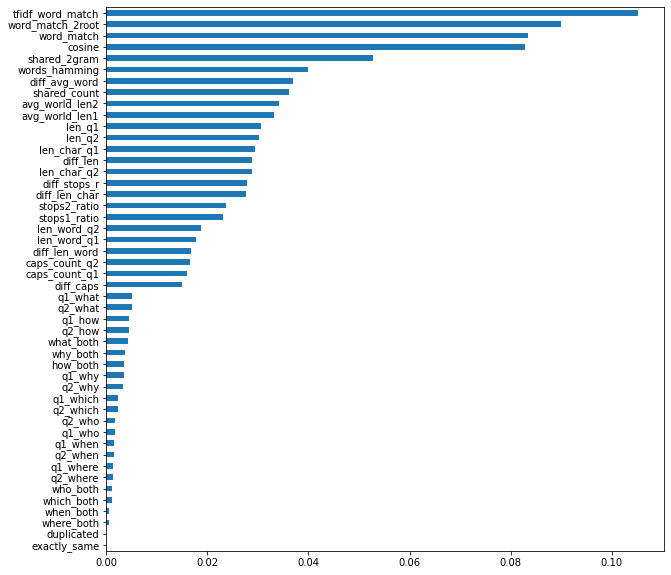

In [98]:
feature_importances = feature_importances.sort_values()
feature_importances.plot(x='importance', kind="barh",figsize=(10,10))

In [100]:
imp_feat = ['avg_world_len1','avg_world_len2', 'diff_avg_word', 'words_hamming', 'shared_count', 'shared_2gram', 'word_match', 'cosine', 
            'word_match_2root', 'tfidf_word_match','stops1_ratio', 'stops2_ratio', 'diff_stops_r', 'diff_len', 'diff_len_char', 'len_q1', 
            'len_char_q1','len_char_q2', 'len_q2'
            ]
#print(feature_importances>0.02)
X_train = X_train[imp_feat]
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train.fillna(0), y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [101]:
X_test = X_test[imp_feat]
y_pred = rfc.predict(X_test.fillna(0))
print("logloss : ", log_loss(y_test, y_pred))
print("accuracy : ", accuracy_score(y_test, y_pred))

logloss :  7.802500906108538
accuracy :  0.7740978010833808


In [104]:
arr = np.array([[0.372560, 0.610377, 0.571429, 4.0,	1.000000,1.200000,0.416667,	0.795192,	0.785714,	-0.200000,	
                 66,	57,	9,	1,	1,	0,	53,	46, 7,	14,	12,	2,	3.785714,	3.833333,	-0.047619,	0,	0,	0,	0,	
                 0,	1,	1,	1,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0]])
#np.reshape(arr, ())
arr

array([[ 3.725600e-01,  6.103770e-01,  5.714290e-01,  4.000000e+00,
         1.000000e+00,  1.200000e+00,  4.166670e-01,  7.951920e-01,
         7.857140e-01, -2.000000e-01,  6.600000e+01,  5.700000e+01,
         9.000000e+00,  1.000000e+00,  1.000000e+00,  0.000000e+00,
         5.300000e+01,  4.600000e+01,  7.000000e+00,  1.400000e+01,
         1.200000e+01,  2.000000e+00,  3.785714e+00,  3.833333e+00,
        -4.761900e-02,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  1.000000e+00,  1.000000e+00,
         1.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00]])

In [105]:
import pickle
pickle.dump(clr, open('model.pkl', 'wb'))
mdl = pickle.load(open('model.pkl', 'rb'))

#arr = np.ndarray((len(arr),2))
p = predict_lgb(mdl,arr)
p

array([0.41859744])

In [106]:
arr

array([[ 3.725600e-01,  6.103770e-01,  5.714290e-01,  4.000000e+00,
         1.000000e+00,  1.200000e+00,  4.166670e-01,  7.951920e-01,
         7.857140e-01, -2.000000e-01,  6.600000e+01,  5.700000e+01,
         9.000000e+00,  1.000000e+00,  1.000000e+00,  0.000000e+00,
         5.300000e+01,  4.600000e+01,  7.000000e+00,  1.400000e+01,
         1.200000e+01,  2.000000e+00,  3.785714e+00,  3.833333e+00,
        -4.761900e-02,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  1.000000e+00,  1.000000e+00,
         1.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00]])

In [108]:
predict_lgb(mdl,arr)

array([0.41859744])

In [ ]:
def create_features():
  quest1 = input("quest1 : ")
  quest2 = input('quest2 : ')
  print("Quest 1 : {}\nQuest2 : {}".format(quest1, quest2))
  

create_features()